In [1]:
import numpy as np
import pandas as pd

import os, glob

from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt

import ipywidgets as widgets
from traitlets import dlink
from IPython.display import display, clear_output

import lmfit

from pyrixs import process1d


import h5py

%matplotlib nbagg

In [2]:
#global Data
Data = OrderedDict({
'raw_spectra' : pd.Series(np.array([])),
'shifts' : pd.Series(np.array([])),
'reference' : '',
'aligned_spectra' : pd.Series(np.array([])),
'raw_spectrum' : pd.Series(np.array([])),
'calibrated_spectrum' : pd.Series(np.array([])),
'meta': '',
'save_filename': '',
'fit_result' : None
})

AXES = OrderedDict(ax1=None, ax2=None, ax3=None, ax4=None)

In [3]:
## SEPARATE FUNCTIONS DEFINED HERE ##
def get_E_pol(search_path, filename):
    """Get Photon energy and polarization from SLS h5 file"""
    with h5py.File(os.path.join(search_path, filename), mode='r') as h5file:
        ein = np.mean(h5file['entry']['instrument']['NDAttributes']['PhotonEnergy'].value)
        temp = np.mean(h5file['entry']['instrument']['NDAttributes']['SampleTemp'].value)
        pol10 = np.mean(h5file['entry']['instrument']['NDAttributes']['PolarMode'].value)
    if pol10 == 0:
        pol = 'LH'
    elif pol10 == 1:
        pol = 'LV'
    return ein, pol, temp


def check_processed(search_path,filename):
    """Check if spectrum has been aligned before. If so load previously used parameters."""
    try:
        processed_file = open(os.path.join(search_path, filename),'r').readlines()
        message = 'It looks like these scans have been processed!\n'
        message += 'The parameters that were used will be loaded.\n\n'
        message_widget.value += message
        for line in processed_file:
            if 'Align min' in line:
                align_min_widget.value = float(line.split('=')[-1])
            elif 'Align max' in line:
                align_max_widget.value = float(line.split('=')[-1])
            elif 'Zero energy pixel ' in line:
                zero_energy_widget.value = float(line.split('=')[-1])
                
    except FileNotFoundError:
        return
    
# unused, but keep for now. Delete later
def test_files_exist(folder, filenames):
    for filename in filenames:
        filepath = os.path.join(folder, filename)
        assert os.path.isfile(filepath), "{} Does not exist".format(filepath)

In [4]:
## WIDGETS DEFINED HERE ##

# Folder to search images for
input_folder_widget = widgets.Text(
    value='test_data/',  
    description='Input folder',
    width='500px',
)

# Folder to search background for
output_folder_widget = widgets.Text(
    value='TEST/',  
    description='Output folder',
    width='500px',
)

ee_pix_widget = widgets.FloatText(
    value=0.00915,  
    description='Energy per pixel',
    width='500px',
)


display_shifts_widget =widgets.HTML(
    value="",
)

output_filename_widget = widgets.Text(
    value='file_out_name',  
    description='Output filename',
    width='500px',
)

scan_number_widget = widgets.Text(
    value='0609',  
    description='Scan number',
    width='500px',
)

output_header_widget = widgets.Text(
    value='description of sample and conditions',
    description='Output header',
    width='500px',
)

load_plot_button = widgets.Button(
    description='Load and plot data',
)

fit_button = widgets.Button(
    description='Fit',
)

align_min_widget = widgets.FloatText(description='Align min', value=100)
align_max_widget = widgets.FloatText(description='Align max', value=3000)
zero_energy_widget = widgets.FloatText(description='Zero energy pixel',value=900)

reset_shifts_button = widgets.Button(description = 'Reset shifts')

plot_range_widget = widgets.IntRangeSlider(
    value=[1, 3200],
    min=0,
    max=3500,
    step=10,
    description='Plot pixel limit',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='i',
    slider_color='white',
    color='black',
    layout=widgets.Layout(width='50%')
)

message_widget = widgets.Textarea(description="Messages", value = '', width='2000px', height='2000px')

In [5]:
## FUNCTIONS BOUND TO WIDGETS ##
def wrap_load_plot(change):

    Data['meta'] = '# ' + output_header_widget.value + '\n'
    scans = scan_number_widget.value.split()
    filenames = ['Co_' + '{:04d}_d{}.h5'.format(int(scan), det) for det in [1,2,3] for scan in scans]
    ein, pol, temp = get_E_pol(input_folder_widget.value, filenames[0])
    Data['save_filename'] = output_filename_widget.value + '_{:0.2f}eV_{}.dat'.format(ein,pol)
    
    check_processed(output_folder_widget.value,Data['save_filename'])
    
    Data['raw_spectra'] = process1d.load_spectra(input_folder_widget.value, filenames)
    
    if len(Data['raw_spectra'].columns) != len(Data['shifts']):
        Data['shifts'] = pd.Series(data=np.zeros(len(Data['raw_spectra'].columns)), index=Data['raw_spectra'].columns)
    else: 
        Data['shifts'].index = pd.Index(filenames)
    
    Data['reference'] = Data['raw_spectra'].columns[0]
    display_shifts_widget.value = pd.DataFrame(Data['shifts'], columns=['shifts']).to_html()
    process_plot(Data)
    
    message = 'Loaded \n' + '\n'.join(filenames) + '\n\n'
    message_widget.value += message

load_plot_button.on_click(wrap_load_plot)

def process_plot(Data):
    
    #clear_output()

    Data['aligned_spectra'] = process1d.apply_shifts(Data['raw_spectra'].copy(), Data['shifts'])

    raw_spectrum, _ = process1d.sum_spectra(Data['aligned_spectra'], Data['shifts'])
    Data['calibrated_spectrum'] = process1d.calibrate_spectrum(raw_spectrum.copy(), zero_energy_widget.value, 
                                                               -1*ee_pix_widget.value)
    
    fig = plt.figure(1, figsize=(9,9))
    fig.clf()
    
    ax1 = fig.add_subplot(221)
    art1 = process1d.plot_spectra(ax1, Data['raw_spectra'], align_min=align_min_widget.value, align_max=align_max_widget.value)
    ax1.axvline(x=zero_energy_widget.value, linestyle=':', color='k')
    ax1.set_xlim(plot_range_widget.value[0],plot_range_widget.value[1])
    
    ax2 = fig.add_subplot(222)
    art2 = process1d.plot_shifts(ax2, Data['shifts'])
    labels = [item.get_text() for item in ax2.get_xticklabels()]
    ax2.set_xticklabels(labels, rotation=20)
    
    ax3 = fig.add_subplot(223)
    art3 = process1d.plot_spectra(ax3, Data['aligned_spectra'])
    ax3.set_xlim(plot_range_widget.value[0],plot_range_widget.value[1])
    
    ax4 = fig.add_subplot(224)
    art4 = process1d.plot_sum(ax4, Data['calibrated_spectrum'])
    ax4.axvline(0, linestyle=':', color='k')
    ax4.set_xlim((plot_range_widget.value[1]-zero_energy_widget.value)*(-1)*ee_pix_widget.value,
             (plot_range_widget.value[0]-zero_energy_widget.value)*(-1)*ee_pix_widget.value)
    
    ax1.legend_.remove()
    ax3.legend_.remove()
    
    AXES.update(OrderedDict(ax1=ax1, ax2=ax2, ax3=ax3, ax4=ax4))

def wrap_reset_shifts(change):
    Data['shifts'] = pd.Series(data=np.zeros(len(Data['raw_spectra'].columns)), index=Data['raw_spectra'].columns)
    display_shifts_widget.value = pd.DataFrame(Data['shifts'], columns=['shifts']).to_html()
    process_plot(Data)
    
    message = "Shifts are \n" + Data['shifts'].to_string() + "\n\n"
    message_widget.value += message

reset_shifts_button.on_click(wrap_reset_shifts)

align_button = widgets.Button(description = 'Align')

def wrap_align(change):

    # Align spectra
    Data['shifts'] = process1d.get_shifts(Data['raw_spectra'], Data['raw_spectra'][Data['reference']], 
                                  align_min=align_min_widget.value, align_max=align_max_widget.value, background=0.)
    display_shifts_widget.value = pd.DataFrame(Data['shifts'], columns=['shifts']).to_html()
    process_plot(Data)
    
    message = "Shifts are \n" + Data['shifts'].to_string() + "\n"
    message_widget.value += message
    

align_button.on_click(wrap_align)

save_data_button = widgets.Button(description = 'Save data')

def wrap_fit(change):
    
    xmin, xmax, ymin, ymax = AXES['ax1'].axis()
    spec = Data['raw_spectra'][Data['reference']]
    cut_spec = spec[(spec.index >= xmin) & (spec.index <= xmax)]
    
    Data['fit_result'] = process1d.fit_elastic(cut_spec.index, cut_spec.values, xmin, xmax, ymin, ymax)
    
    zero_energy_widget.value = Data['fit_result'].best_values['center']
    
    process_plot(Data)
    AXES['ax1'].plot(cut_spec.index, Data['fit_result'].best_fit, 'rx-')
    
    message = "Fit result: \n"
    message += "\n".join(["{} = {:.4f}".format(var, val) for var, val in Data['fit_result'].best_values.items()])
    message += "\n"
    message_widget.value += message

fit_button.on_click(wrap_fit)

def wrap_save_data(change):
    
    Data['meta'] += '# Energy per pixel = {:0.1f} meV\n'.format(ee_pix_widget.value*1000.)
    Data['meta'] += '# Zero energy pixel = {:0.2f}\n'.format(zero_energy_widget.value)
    Data['meta'] += '# Align min = {:0.2f}\n'.format(align_min_widget.value)
    Data['meta'] += '# Align max = {:0.2f}\n'.format(align_max_widget.value)
    
    process_meta = ''.join('# {}\t {} \n'.format(name, shift) 
                           for name, shift in Data['shifts'].iteritems())

        
    Data['meta'] += process_meta + '# Energy (eV) Intensity\n'
    
    save_filepath = os.path.join(output_folder_widget.value, Data['save_filename'])
    process1d.save_spectrum(save_filepath, Data['calibrated_spectrum'], Data['meta'])
    message = "Wrote to {}".format(save_filepath) + '\n'
    message_widget.value += message

save_data_button.on_click(wrap_save_data)

<IPython.core.display.Javascript object>


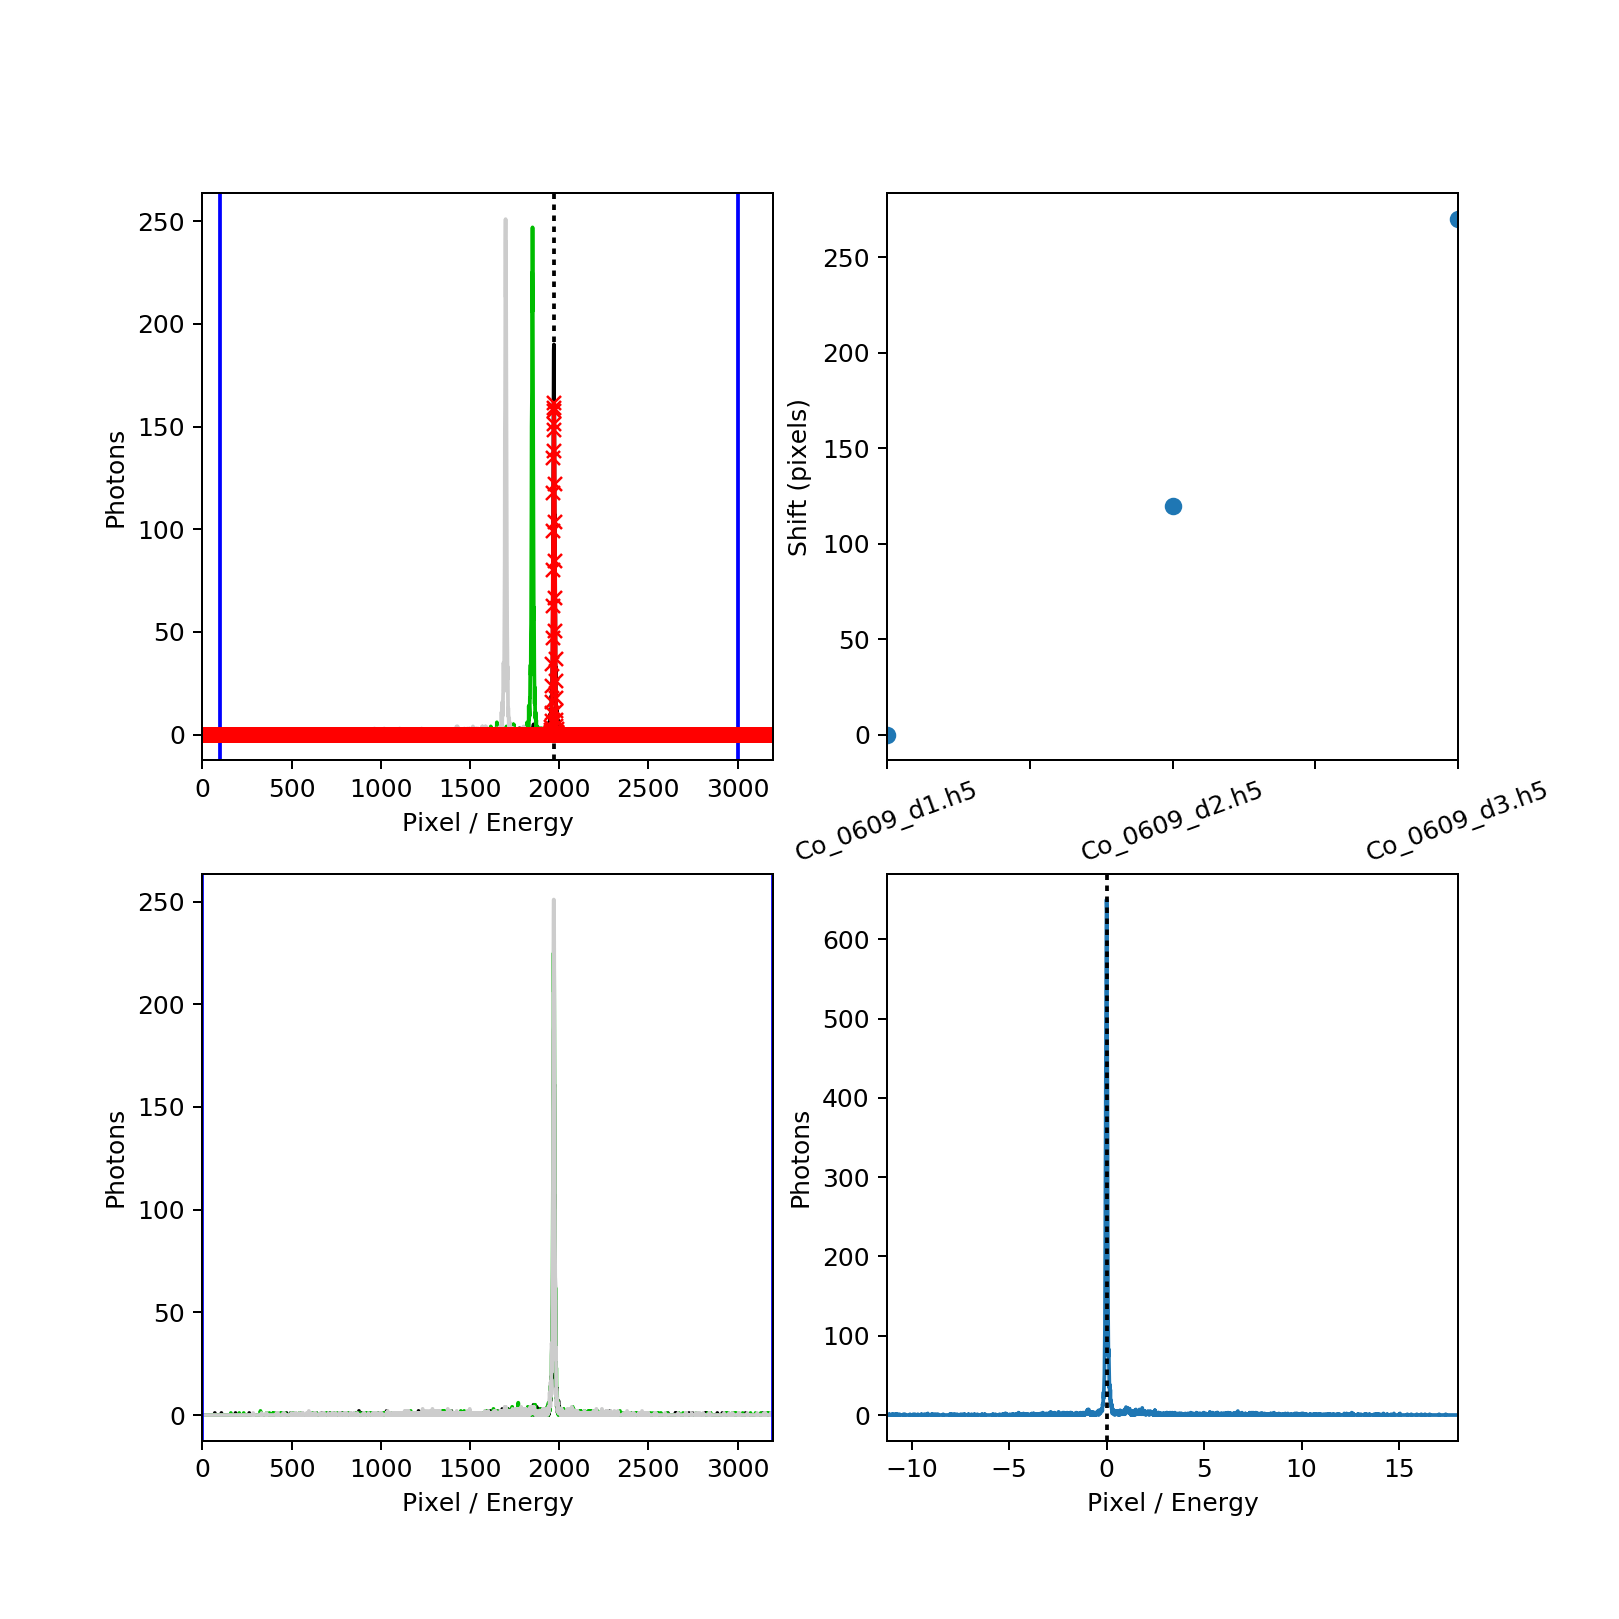

In [6]:
## DISPLAY WIDGETS ##
display(widgets.HBox((input_folder_widget, output_folder_widget, output_header_widget)))
display(widgets.HBox((output_filename_widget,scan_number_widget)))
display(widgets.HBox((zero_energy_widget,align_min_widget,align_max_widget)))
display(widgets.HBox((ee_pix_widget,plot_range_widget)))
display(widgets.HBox((load_plot_button, reset_shifts_button, fit_button, align_button, save_data_button)))

In [7]:
message_widget

In [8]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show/hide code."></form>''')